In [1]:
!pip install pymysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.7 MB/s eta 0:00:00


1. 데이터 로드 밎 전처리

In [16]:
import pandas as pd
import pymysql
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# MySQL 연결 정보
host = 'database-1.cle8iqa6gu0p.us-east-1.rds.amazonaws.com'
user = 'root'
password = 's8rf1835!'
database = 'mydatabase'

def connect_to_mysql():
    return pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )

# MySQL에서 데이터 불러오기
def load_data_from_mysql(table_name):
    connection = connect_to_mysql()
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, connection)
    connection.close()
    return df

# 데이터 로드
allergy = load_data_from_mysql('allergy')
food = load_data_from_mysql('food')
fridge_contents = load_data_from_mysql('fridge_contents')
member_data = load_data_from_mysql('member_data')
member_allergies = load_data_from_mysql('member_allergies')
member_preferences = load_data_from_mysql('member_preferences')
recipe_ingredients = load_data_from_mysql('recipe_ingredients')
recipe = load_data_from_mysql('recipe')
shopping_lists = load_data_from_mysql('shopping_lists')

# 데이터 전처리
fridge_contents['purchase_date'] = pd.to_datetime(fridge_contents['purchase_date'])
fridge_contents['expiry_date'] = pd.to_datetime(fridge_contents['expiry_date'])
fridge_contents['days_remaining'] = (fridge_contents['expiry_date'] - pd.Timestamp.now()).dt.days

# 날짜 컬럼을 문자열로 변환
fridge_contents['purchase_date'] = fridge_contents['purchase_date'].astype(str)
fridge_contents['expiry_date'] = fridge_contents['expiry_date'].astype(str)
fridge_contents['deletedat'] = fridge_contents['deletedat'].astype(str)

# 데이터프레임 통합
merged_data = fridge_contents.merge(food, on='food_id').merge(member_data, on='member_id')

# 통합된 데이터 확인
print(merged_data.head())
print(shopping_lists.head())
print(member_allergies.head())


<ipython-input-16-3ad73e206a36>:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


   member_id  food_id  quantity purchase_date expiry_date deletedat_x  \
0          1      124         2    2024-04-28  2024-06-05        None   
1          1      165         5    2024-04-19  2024-07-16        None   
2          1      184         5    2024-05-04  2024-06-28        None   
3          1      190         4    2024-04-29  2024-07-22        None   
4          1      221         1    2024-04-22  2024-06-24        None   

   days_remaining  fridge_id food_name storage_method  ...    password  \
0               5          1      월계수잎             실온  ...  ce*&n2By5!   
1              46          1    아스파라거스             냉장  ...  ce*&n2By5!   
2              28          1       백설탕             실온  ...  ce*&n2By5!   
3              52          1        맥주             냉장  ...  ce*&n2By5!   
4              24          1        만두             냉동  ...  ce*&n2By5!   

   is_family_head gender age_group is_vegan_y  preferred_cuisine  \
0               0     남자       10대          1   

2. 추천 시스템 구현

In [17]:
class RecommendationSystem:
    def __init__(self, food_table, member_preference_table, member_allergies_table, member_data, recipe_table, recipe_ingredients_table):
        self.food_table = food_table
        self.member_preference_table = member_preference_table
        self.member_allergies_table = member_allergies_table
        self.member_data = member_data
        self.recipe_table = recipe_table
        self.recipe_ingredients_table = recipe_ingredients_table

    def recommend_food(self, member_id):
        member = self.member_data[self.member_data['member_id'] == member_id]
        if member['is_family_head'].values[0] == 1:
            family_members = self.member_data[self.member_data['member_id'] == member_id]
        else:
            family_members = self.member_data[self.member_data['family_id'] == member['family_id'].values[0]]
        family_ids = family_members['member_id'].tolist()

        preferred_foods = self.member_preference_table[self.member_preference_table['member_id'].isin(family_ids)]
        allergies = self.member_allergies_table[self.member_allergies_table['member_id'].isin(family_ids)]

        preferred_cuisines = family_members['preferred_cuisine'].tolist()
        non_preferred_cuisines = family_members['non_preferred_cuisine'].tolist()
        preferred_ingredients = family_members['preferred_ingredient'].tolist()
        non_preferred_ingredients = family_members['non_preferred_ingredient'].tolist()
        is_vegan = family_members['is_vegan'].tolist()
        gender = family_members['gender'].tolist()
        age_group = family_members['age_group'].tolist()

        recommended_foods = self.food_table[
            (~self.food_table['allergy_id'].isin(allergies['allergy_id'])) &
            (self.food_table['food_name'].isin(preferred_ingredients)) &
            (~self.food_table['food_name'].isin(non_preferred_ingredients)) &
            ((self.food_table['is_vegan'] == is_vegan[0]) | (is_vegan[0] == 0)) &
            (self.food_table['cuisine_type'].isin(preferred_cuisines)) &
            (~self.food_table['cuisine_type'].isin(non_preferred_cuisines))
        ]

        return recommended_foods

    def recommend_recipe(self, member_id):
        member = self.member_data[self.member_data['member_id'] == member_id]
        if member['is_family_head'].values[0] == 1:
            family_members = self.member_data[self.member_data['member_id'] == member_id]
        else:
            family_members = self.member_data[self.member_data['family_id'] == member['family_id'].values[0]]
        family_ids = family_members['member_id'].tolist()

        preferred_cuisines = family_members['preferred_cuisine'].tolist()
        non_preferred_cuisines = family_members['non_preferred_cuisine'].tolist()
        preferred_ingredients = family_members['preferred_ingredient'].tolist()
        non_preferred_ingredients = family_members['non_preferred_ingredient'].tolist()
        is_vegan = family_members['is_vegan'].tolist()
        age_group = family_members['age_group'].tolist()

        recommended_recipes = self.recipe_table[
            (self.recipe_table['cuisine_type'].isin(preferred_cuisines)) &
            (~self.recipe_table['cuisine_type'].isin(non_preferred_cuisines)) &
            ((self.recipe_table['is_vegan'] == is_vegan[0]) | (is_vegan[0] == 0))
        ]

        recommended_recipes = recommended_recipes.merge(self.recipe_ingredients_table, on='recipe_id')
        recommended_recipes = recommended_recipes[recommended_recipes['food_id'].isin(preferred_ingredients)]

        return recommended_recipes

    def display_recommendations(self, recommendations):
        for idx, row in recommendations.iterrows():
            print(f"Food: {row['food_name']}, Image URL: {row['food_image_url']}")
            self.display_image(row['food_image_url'])

    def display_image(self, url):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis('off')
        plt.show()


3. 강화 학습 환경 및 에이전트 구현

In [18]:
class FridgeEnv:
    def __init__(self, fridge_contents):
        self.fridge_contents = fridge_contents

    def reset(self):
        # 환경 초기화
        state = self.fridge_contents.sample().copy()
        state.drop(columns=['purchase_date', 'expiry_date', 'deletedat'], inplace=True)
        return np.reshape(state.to_numpy(), [1, len(state.columns)]).astype(np.float32)

    def step(self, action):
        # 냉장고 상태와 행동에 따른 보상 및 다음 상태를 정의
        food_item = self.fridge_contents.iloc[action]
        reward = 0
        if food_item['days_remaining'] <= 0:
            reward = -10  # 유통기한이 지난 경우 벌점
        elif food_item['days_remaining'] > 0:
            reward = 10  # 유통기한 내 소비한 경우 가점
        next_state = self.fridge_contents.sample().copy()
        next_state.drop(columns=['purchase_date', 'expiry_date', 'deletedat'], inplace=True)
        next_state = np.reshape(next_state.to_numpy(), [1, len(next_state.columns)]).astype(np.float32)
        done = random.choice([True, False])  # 임의의 종료 상태
        return next_state, reward, done

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # 할인율
        self.epsilon = 1.0  # 탐험 확률 초기값
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # 신경망 모델 생성
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


4, 학습 및 성능평가

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 18ms/step
episode: 57/100, score: 2, total_reward: 30, e: 0.81
episode: 58/100, score: 0, total_reward: 10, e: 0.81
1/1 [==============================] - 0s 23ms/step
episode: 59/100, score: 8, total_reward: 10, e: 0.78
episode: 60/100, score: 0, total_reward: -10, e: 0.78
1/1 [==============================] - 0s 19ms/step
episode: 61/100, score: 2, total_reward: 10, e: 0.77
episode: 62/100, score: 0, total_reward: -10, e: 0.77
1/1 [==============================] - 0s 17ms/step
episode: 63/100, score: 6, total_reward: 70, e: 0.75
episode: 64/100, score: 0, total_reward: 10, e: 0.75
1/1 [==============================] - 0s 19ms/step
episode: 65/100, score: 1, total_reward: 20, e: 0.75
episode: 66/100, score: 0, total_reward: 10, e: 0.75
1/1 [==============================] - 0s 22ms/step
episode: 67/100, score: 3, total_reward: 40, e: 0.74
1/1 [==============================] - 0s 20ms/step
episode: 68/100

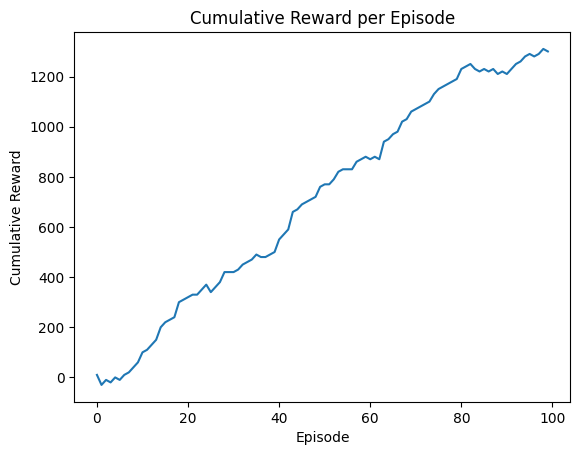

1/1 [==============================] - 0s 23ms/step
Average reward over 10 evaluation episodes: 17.0
F1 Score for food recommendation system: 0
F1 Score for recipe recommendation system: 0


In [19]:
# 환경 및 에이전트 초기화
state_size = len(fridge_contents.columns) - 3  # 날짜와 시간 컬럼을 제외한 수치형 컬럼의 개수
action_size = len(food)
env = FridgeEnv(fridge_contents)
agent = DQNAgent(state_size, action_size)

# 학습
episode_rewards = []
episodes = 100  # 에피소드 수를 늘려서 충분히 학습
steps_per_episode = 100  # 각 에피소드의 최대 단계 수

for e in range(episodes):
    state = env.reset()  # 초기 상태
    total_reward = 0
    for time in range(steps_per_episode):
        action = agent.act(state)
        next_state, reward, done = env.step(action)  # 환경에 따른 보상과 다음 상태
        total_reward += reward
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size]).astype(np.float32)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
        if len(agent.memory) > 64:  # 배치 크기 증가
            agent.replay(64)
    episode_rewards.append(total_reward)
    print(f"episode: {e}/{episodes}, score: {time}, total_reward: {total_reward}, e: {agent.epsilon:.2}")

# 누적 보상 계산
cumulative_rewards = np.cumsum(episode_rewards)

# 누적 보상 그래프 그리기
plt.plot(range(len(cumulative_rewards)), cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward per Episode')
plt.show()

# 성능 평가
def evaluate(agent, env, episodes=10):
    total_rewards = 0
    steps_per_episode = 50  # 평가 시 단계 수를 줄여서 시간 단축
    for _ in range(episodes):
        state = env.reset()
        episode_reward = 0
        for _ in range(steps_per_episode):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            state = np.reshape(next_state, [1, state_size]).astype(np.float32)
            episode_reward += reward
            if done:
                break
        total_rewards += episode_reward
    return total_rewards / episodes

# 평가
avg_reward = evaluate(agent, env)
print(f"Average reward over 10 evaluation episodes: {avg_reward}")

def compute_f1_score(recommendations, actuals):
    tp = len(set(recommendations) & set(actuals))
    fp = len(set(recommendations) - set(actuals))
    fn = len(set(actuals) - set(recommendations))
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# 추천 시스템 평가
member_id = 1  # 예시 멤버 ID
recommender = RecommendationSystem(food, member_preferences, member_allergies, member_data, recipe, recipe_ingredients)
recommendations = recommender.recommend_food(member_id)
actuals = fridge_contents[fridge_contents['member_id'] == member_id]['food_id'].tolist()
f1_food = compute_f1_score(recommendations['food_id'].tolist(), actuals)
print(f"F1 Score for food recommendation system: {f1_food}")

# 추천 결과 표시
recommender.display_recommendations(recommendations)

# 레시피 추천 및 평가
recipe_recommendations = recommender.recommend_recipe(member_id)
actual_recipes = recipe_ingredients[recipe_ingredients['recipe_id'].isin(recipe_recommendations['recipe_id'])]['food_id'].tolist()
f1_recipe = compute_f1_score(recipe_recommendations['food_id'].tolist(), actual_recipes)
print(f"F1 Score for recipe recommendation system: {f1_recipe}")

# 레시피 추천 결과 표시
for idx, row in recipe_recommendations.iterrows():
    print(f"Recipe: {row['recipe_name']}, Image URL: {row['recipe_image_url']}")
    recommender.display_image(row['recipe_image_url'])


In [20]:
# 각 데이터프레임의 열 정보를 추출
dataframes = {
    'allergy': allergy,
    'food': food,
    'fridge_contents': fridge_contents,
    'member_data': member_data,
    'member_allergies': member_allergies,
    'member_preferences': member_preferences,
    'recipe_ingredients': recipe_ingredients,
    'recipe': recipe,
    'shopping_lists': shopping_lists
}

# 데이터프레임의 열 이름 출력
for name, df in dataframes.items():
    print(f"{name} columns: {df.columns.tolist()}")


allergy columns: ['allergy_id', 'allergy_name', 'deletedat']
food columns: ['food_id', 'food_name', 'storage_method', 'allergy_id', 'is_vegan', 'deletedat', 'food_image_url', 'cuisine_type']
fridge_contents columns: ['member_id', 'food_id', 'quantity', 'purchase_date', 'expiry_date', 'deletedat', 'days_remaining', 'fridge_id']
member_data columns: ['member_id', 'family_id', 'member_name', 'email', 'password', 'is_family_head', 'gender', 'age_group', 'is_vegan', 'preferred_cuisine', 'non_preferred_cuisine', 'preferred_ingredient', 'non_preferred_ingredient', 'deletedat']
member_allergies columns: ['member_id', 'allergy_id']
member_preferences columns: ['member_preference_id', 'member_id', 'recipe_id', 'preference_level', 'liked', 'deletedat']
recipe_ingredients columns: ['recipe_ingredients_id', 'recipe_id', 'food_id', 'quantity', 'deletedat']
recipe columns: ['recipe_id', 'recipe_name', 'cuisine_type', 'description', 'recipe_image_url', 'is_vegan', 'deletedat']
shopping_lists columns: 

5. 추천시스템 food성능 개선

In [50]:
import pandas as pd
import pymysql
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# MySQL 연결 정보
host = 'database-1.cle8iqa6gu0p.us-east-1.rds.amazonaws.com'
user = 'root'
password = 's8rf1835!'
database = 'mydatabase'

def connect_to_mysql():
    return pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )

# 데이터 로드
connection = connect_to_mysql()

food_table = pd.read_sql("SELECT * FROM food", connection)
recipe_ingredients = pd.read_sql("SELECT * FROM recipe_ingredients", connection)
recipe_table = pd.read_sql("SELECT * FROM recipe", connection)
member_data = pd.read_sql("SELECT * FROM member_data", connection)
member_allergies = pd.read_sql("SELECT * FROM member_allergies", connection)
member_preferences = pd.read_sql("SELECT * FROM member_preferences", connection)
fridge_contents = pd.read_sql("SELECT * FROM fridge_contents", connection)

connection.close()

class ImprovedRecommendationSystem:
    def __init__(self, food_table, member_preferences, member_allergies, member_data, recipe_table, recipe_ingredients_table, fridge_contents):
        self.food_table = food_table
        self.member_preferences = member_preferences
        self.member_allergies = member_allergies
        self.member_data = member_data
        self.recipe_table = recipe_table
        self.recipe_ingredients_table = recipe_ingredients_table
        self.fridge_contents = fridge_contents

    def recommend_food(self, member_id):
        member = self.member_data[self.member_data['member_id'] == member_id]
        if member.empty:
            return pd.DataFrame()

        family_id = member['family_id'].values[0]
        family_members = self.member_data[self.member_data['family_id'] == family_id]
        family_ids = family_members['member_id'].tolist()

        allergies = self.member_allergies[self.member_allergies['member_id'].isin(family_ids)]
        preferred_ingredients = member['preferred_ingredient'].values[0].split(',')
        non_preferred_ingredients = member['non_preferred_ingredient'].values[0].split(',')

        # 냉장고에 있는 현재 식품 데이터 활용
        fridge_food_ids = self.fridge_contents[self.fridge_contents['member_id'] == member_id]['food_id'].tolist()
        fridge_foods = self.food_table[self.food_table['food_id'].isin(fridge_food_ids)]

        recommended_foods = fridge_foods[
            (~fridge_foods['allergy_id'].isin(allergies['allergy_id'])) &
            ((fridge_foods['food_name'].isin(preferred_ingredients)) |
             (~fridge_foods['food_name'].isin(non_preferred_ingredients)))
        ]

        return recommended_foods

def compute_f1_score(recommendations, actuals):
    tp = len(set(recommendations) & set(actuals))
    fp = len(set(recommendations) - set(actuals))
    fn = len(set(actuals) - set(recommendations))
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# 추천 시스템 인스턴스화 및 평가
recommender = ImprovedRecommendationSystem(food_table, member_preferences, member_allergies, member_data, recipe_table, recipe_ingredients, fridge_contents)
recommendations = recommender.recommend_food(101)  # 가상 사용자에 대한 추천
actuals = fridge_contents[fridge_contents['member_id'] == 101]['food_id'].tolist()
f1_food = compute_f1_score(recommendations['food_id'].tolist(), actuals)
print(f"F1 Score for food recommendation system: {f1_food}")


<ipython-input-50-0aa5cd07fa6f>:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  food_table = pd.read_sql("SELECT * FROM food", connection)
<ipython-input-50-0aa5cd07fa6f>:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  recipe_ingredients = pd.read_sql("SELECT * FROM recipe_ingredients", connection)
<ipython-input-50-0aa5cd07fa6f>:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  recipe_table = pd.read_sql("SELECT * FROM recipe", connection)
<ipython-input-50-0aa5cd07fa6f>:28: UserWarning: pandas only supports SQLAlchemy

F1 Score for food recommendation system: 1.0


<ipython-input-50-0aa5cd07fa6f>:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fridge_contents = pd.read_sql("SELECT * FROM fridge_contents", connection)


개선 완료